<a href="https://colab.research.google.com/github/FatimaZahraBoujrad/phishing_classification/blob/main/Content_info__classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the dataset

PHISHING_PATH = "/content/drive/MyDrive/Projet_Phishing/Dataset/phishing30k.csv"
BENIGN_PATH="/content/drive/MyDrive/Projet_Phishing/Dataset/benign30k.csv"

phishing = pd.read_csv(PHISHING_PATH)
benign = pd.read_csv(BENIGN_PATH)

## Feature engineering

In [4]:
def url_features(df):
    out = pd.DataFrame(index=df.index)

    out["url_length"] = df["destination_url"].fillna("").str.len()

    out["subdomain_length"] = df["subdomain"].fillna("").str.len()

    out["subdomain_token_count"] = (
        df["subdomain"]
        .fillna("")
        .apply(lambda x: len([t for t in x.split(".") if t]))
    )

    out["has_multiple_subdomains"] = out["subdomain_token_count"] > 1

    return out


In [5]:
BRAND_KEYWORDS = [
    "facebook", "meta", "google", "paypal",
    "microsoft", "apple", "amazon", "instagram"
]

URGENCY_KEYWORDS = [
    "urgent", "verify", "suspend", "restricted",
    "violation", "alert", "warning", "immediately"
]

ACTION_KEYWORDS = [
    "login", "confirm", "update", "review",
    "submit", "secure", "validate"
]


def title_features(df):
    titles = df["title"].fillna("").astype(str)
    out = pd.DataFrame(index=df.index)

    out["title_length"] = titles.str.len()

    out["title_word_count"] = titles.apply(lambda x: len(x.split()))

    out["title_unique_word_ratio"] = titles.apply(
        lambda x: len(set(x.lower().split())) / max(len(x.split()), 1)
    )

    out["title_uppercase_ratio"] = titles.apply(
        lambda x: sum(c.isupper() for c in x) / max(len(x), 1)
    )

    out["title_digit_ratio"] = titles.apply(
        lambda x: sum(c.isdigit() for c in x) / max(len(x), 1)
    )

    out["title_contains_brand"] = titles.str.lower().apply(
        lambda x: any(b in x for b in BRAND_KEYWORDS)
    )

    out["title_contains_urgency"] = titles.str.lower().apply(
        lambda x: any(u in x for u in URGENCY_KEYWORDS)
    )

    out["title_contains_action"] = titles.str.lower().apply(
        lambda x: any(a in x for a in ACTION_KEYWORDS)
    )

    return out


In [6]:
def resource_ratio_features(df):
    out = pd.DataFrame(index=df.index)

    total = df["total_resources"].replace(0, np.nan)

    out["js_ratio"] = df["js_file_count"] / total
    out["css_ratio"] = df["css_file_count"] / total
    out["image_ratio"] = df["image_count"] / total
    out["video_ratio"] = df["video_count"] / total
    out["font_ratio"] = df["font_count"] / total

    out = out.fillna(0)

    return out


In [7]:
def resource_dominance_features(df):
    out = pd.DataFrame(index=df.index)

    resource_cols = {
        "js": df["js_file_count"],
        "css": df["css_file_count"],
        "image": df["image_count"],
        "video": df["video_count"],
        "font": df["font_count"]
    }

    out["resource_type_dominant"] = pd.DataFrame(resource_cols).idxmax(axis=1)

    out["media_heavy_page"] = (
        (df["image_count"] + df["video_count"]) >
        (df["js_file_count"] + df["css_file_count"])
    )

    js_ratio = df["js_file_count"] / df["total_resources"].replace(0, np.nan)
    out["script_heavy_page"] = js_ratio > 0.5

    out = out.fillna(False)

    return out


In [8]:
def resource_complexity_features(df, reuse_threshold=0.7, resource_threshold=None):
    out = pd.DataFrame(index=df.index)

    total = df["total_resources"].replace(0, np.nan)

    out["resource_reuse_ratio"] = df["unique_md5_hashes"] / total

    out["has_high_reuse"] = out["resource_reuse_ratio"] < reuse_threshold

    out["resource_density"] = total / df["unique_file_types"].replace(0, np.nan)

    if resource_threshold is None:
        resource_threshold = df["total_resources"].median()

    out["low_diversity_high_count"] = (
        (df["total_resources"] > resource_threshold) &
        (df["unique_file_types"] <= 2)
    )

    out = out.fillna(0)

    return out


In [9]:
def tech_features(df):
    tech = df["tech_info"].fillna("").str.lower()
    out = pd.DataFrame(index=df.index)

    out["tech_info_missing"] = tech == ""

    out["uses_php"] = tech.str.contains("php")
    out["uses_node"] = tech.str.contains("node|express")
    out["uses_react"] = tech.str.contains("react")
    out["uses_tailwind"] = tech.str.contains("tailwind")
    out["uses_static_host"] = tech.str.contains(
        "surge|netlify|vercel|github|static"
    )

    return out


### combine the dataset

In [10]:
# Add labels
phishing_labeled = phishing.copy()
phishing_labeled["label"] = 1   # 1 = phishing

benign_labeled = benign.copy()
benign_labeled["label"] = 0     # 0 = benign

# Combine datasets
combined_df = pd.concat(
    [phishing_labeled, benign_labeled],
    axis=0,
    ignore_index=True
)

# Optional: shuffle rows
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(combined_df.shape)
combined_df.head()


(59590, 53)


,url,is_https,dns_a_status,dns_a_answer_1,dns_aaaa_status,dns_mx_status,ssl_issuer,ssl_valid_from,ssl_valid_until,ssl_is_valid_cert,...,rd_has_ip,sd_has_ip,attack_pattern_ip,has_history,subdomain_len,tld,is_common_tld,trg,fqdn,label
0,https://monitoringpublic.solaredge.com/mfe/reg...,True,NOERROR,167.86.50.129,NOERROR,NOERROR,DigiCert Inc,2024-04-01,2025-05-02,True,...,1,1,0,0,16,com,1,NaN,monitoringpublic.solaredge.com,0
1,https://www.tempo.pt/bombarral.htm,True,NOERROR,104.18.166.107,NOERROR,NOERROR,Google Trust Services,2025-02-04,2025-05-05,True,...,1,0,0,0,4,pt,0,NaN,www.tempo.pt,0
2,https://shaw-108007.weeblysite.com/,True,NOERROR,74.115.51.54,NOERROR,NOERROR,"Cloudflare, Inc.",2023-09-29,2024-09-27,True,...,1,1,0,0,11,com,1,Other,shaw-108007.weeblysite.com,1
3,https://tflvru.postalii.shop/,True,NOERROR,188.114.96.3,NOERROR,NOERROR,Google Trust Services,2024-07-05,2024-10-03,True,...,1,1,0,0,6,shop,0,National Police Agency JAPAN,tflvru.postalii.shop,1
4,https://domotz.com/press/magnolia-at-best-buy-...,True,NOERROR,18.245.86.119,NOERROR,NOERROR,Amazon,2024-09-15,2025-10-12,True,...,1,0,0,0,4,com,1,NaN,domotz.com,0


In [11]:
url_df = url_features(combined_df)
title_df = title_features(combined_df)
ratio_df = resource_ratio_features(combined_df)
dominance_df = resource_dominance_features(combined_df)
complexity_df = resource_complexity_features(combined_df)
tech_df = tech_features(combined_df)


In [12]:
# Select numeric / ratio features
numeric_features = [
    "url_length",
    "subdomain_length",
    "subdomain_token_count",
    "css_ratio",
    "image_ratio",
    "video_ratio",
    "font_ratio",
    "title_length",
    "title_word_count",
    "title_unique_word_ratio",
    "title_uppercase_ratio",
    "title_digit_ratio",
    "resource_reuse_ratio",
    "file_type_diversity_score",
    "total_resources",
    "unique_file_types",
]

# Boolean features from EDA + original dataset
boolean_features = [
    "title_contains_brand",
    "title_contains_urgency",
    "has_high_reuse",
    "uses_php",
    "has_path",
    "has_duplicate_resources",
    "has_video",
    "has_audio",
    "has_subdomain",
]
infra_features = [
    # --- Analyse Réseau (HAR) ---
    'har_total_requests',
    'har_unique_content_types',
    'har_unique_servers',

    'har_avg_status',
    'har_http_ratio',
    'har_ip_request_ratio',

    'har_free_hosting_ratio',
    'har_external_domain_count',
    'har_missing_security_headers_ratio',

    # --- Infrastructure & Lexical ---
    'rd_has_ip',
    'sd_has_ip',
    'attack_pattern_ip',
    'has_history',
    'subdomain_len',
    'tld',
    'is_common_tld'
]

# Merge all features
final_df = pd.concat(
    [
        combined_df[["label"]],
        url_df,          # url_length, subdomain_length, subdomain_token_count
        title_df[["title_length", "title_word_count", "title_unique_word_ratio",
                  "title_uppercase_ratio", "title_digit_ratio",
                  "title_contains_brand", "title_contains_urgency"]],
        ratio_df[[ "image_ratio", "font_ratio"]],
        complexity_df[["resource_reuse_ratio", "has_high_reuse"]],
        tech_df[["uses_php"]],
        combined_df[["has_path", "has_duplicate_resources",  "has_audio", "has_subdomain"]],
        combined_df[["total_resources", "unique_file_types", "file_type_diversity_score"]],
        combined_df[infra_features],
    ],
    axis=1
)

print(final_df.shape)
final_df.head()


(59590, 40)


,label,url_length,subdomain_length,subdomain_token_count,has_multiple_subdomains,title_length,title_word_count,title_unique_word_ratio,title_uppercase_ratio,title_digit_ratio,...,har_free_hosting_ratio,har_external_domain_count,har_missing_security_headers_ratio,rd_has_ip,sd_has_ip,attack_pattern_ip,has_history,subdomain_len,tld,is_common_tld
0,0,69,30,3,True,22,2,1.0,0.136364,0.000000,...,0.0,4.0,0.583333,1,1,0,0,16,com,1
1,0,34,12,3,True,63,11,1.0,0.063492,0.031746,...,0.0,17.0,0.760274,1,0,0,0,4,pt,0
2,1,35,26,3,True,11,3,1.0,0.181818,0.000000,...,0.0,9.0,0.917808,1,1,0,0,11,com,1
3,1,29,20,3,True,24,1,1.0,0.000000,0.000000,...,0.0,6.0,0.564103,1,1,0,0,6,shop,0
4,0,138,10,2,True,105,17,1.0,0.114286,0.000000,...,0.0,35.0,0.202703,1,0,0,0,4,com,1


In [13]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59590 entries, 0 to 59589
Data columns (total 40 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   label                               59590 non-null  int64  
 1   url_length                          59590 non-null  int64  
 2   subdomain_length                    59590 non-null  int64  
 3   subdomain_token_count               59590 non-null  int64  
 4   has_multiple_subdomains             59590 non-null  bool   
 5   title_length                        59590 non-null  int64  
 6   title_word_count                    59590 non-null  int64  
 7   title_unique_word_ratio             59590 non-null  float64
 8   title_uppercase_ratio               59590 non-null  float64
 9   title_digit_ratio                   59590 non-null  float64
 10  title_contains_brand                59590 non-null  bool   
 11  title_contains_urgency              59590

## Prepare the dataset for training

In [29]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

#  Encode 'tld' as numeric
final_df['tld'] = final_df['tld'].fillna("unknown").astype(str)
le = LabelEncoder()
final_df['tld'] = le.fit_transform(final_df['tld'])


# Fill NaNs and handle infinities
final_df = final_df.fillna(0)
final_df = final_df.replace([np.inf, -np.inf], 0)

In [43]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59590 entries, 0 to 59589
Data columns (total 39 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   label                               59590 non-null  int64  
 1   url_length                          59590 non-null  int64  
 2   subdomain_length                    59590 non-null  int64  
 3   subdomain_token_count               59590 non-null  int64  
 4   title_length                        59590 non-null  int64  
 5   title_word_count                    59590 non-null  int64  
 6   title_unique_word_ratio             59590 non-null  float64
 7   title_uppercase_ratio               59590 non-null  float64
 8   title_digit_ratio                   59590 non-null  float64
 9   title_contains_brand                59590 non-null  bool   
 10  title_contains_urgency              59590 non-null  bool   
 11  image_ratio                         59590

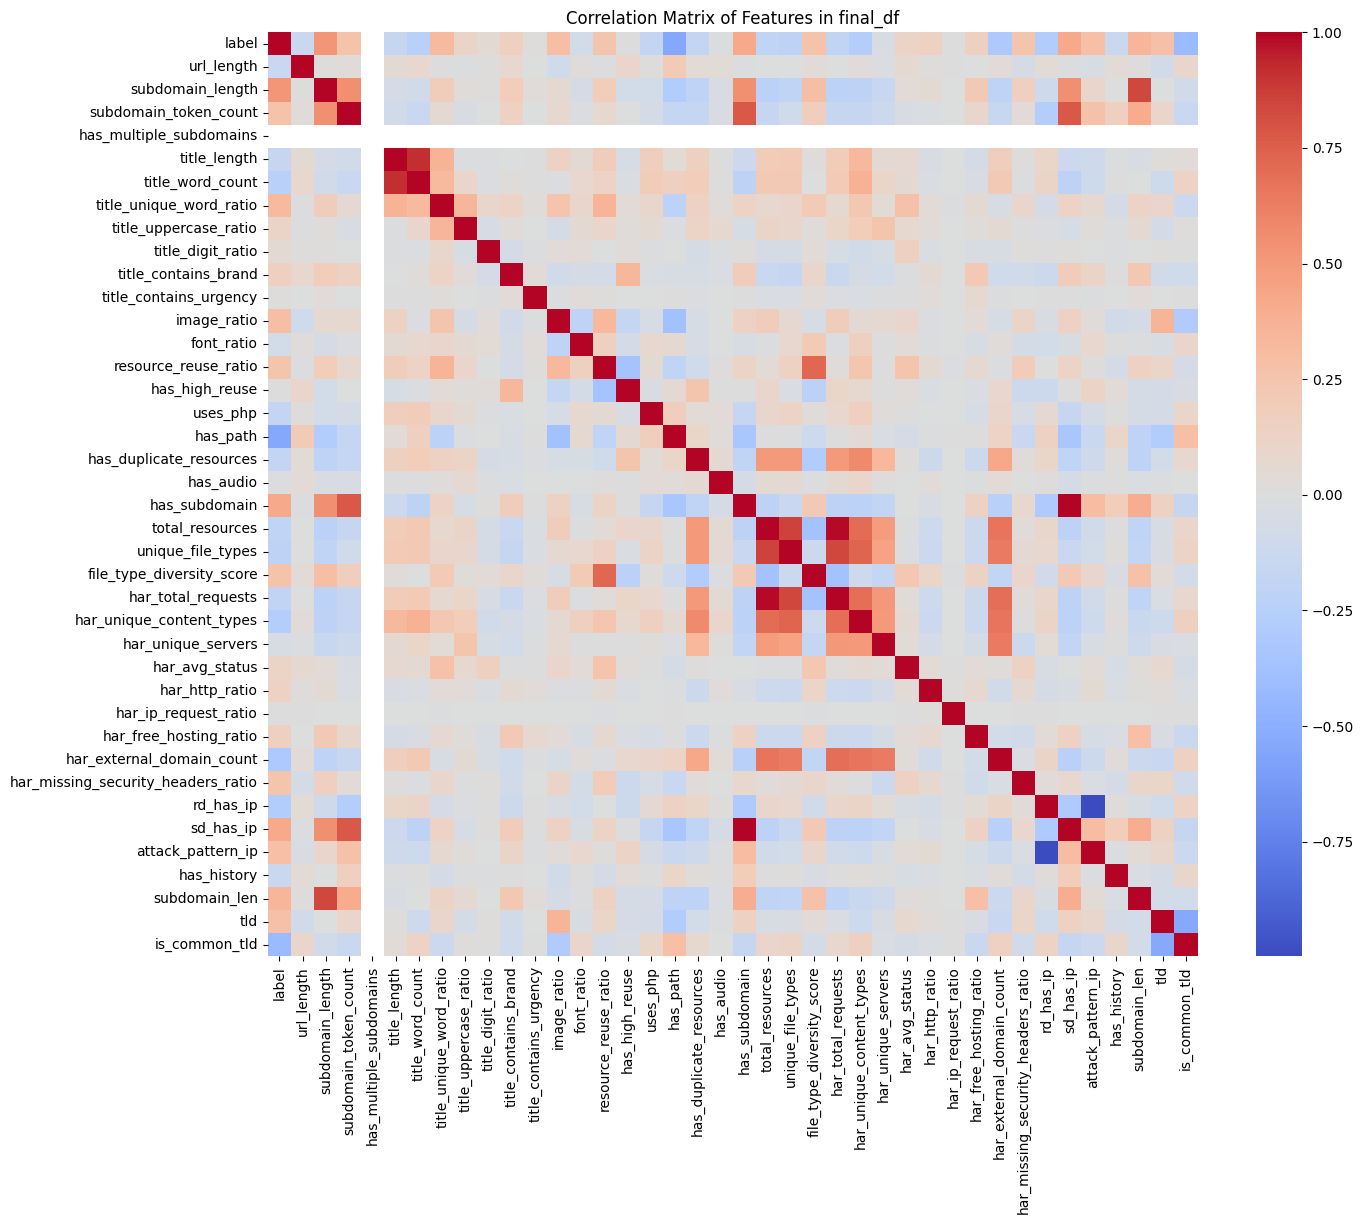

In [39]:
plt.figure(figsize=(15, 12))
sns.heatmap(final_df.corr(numeric_only=True), annot=False, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Features in final_df")
plt.show()


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Target
y = final_df["label"]

# Features
X = final_df.drop(columns=["label"])


In [31]:
# Convert all boolean columns to int
bool_cols = X.select_dtypes(include="bool").columns
X[bool_cols] = X[bool_cols].astype(int)


In [32]:
# Numeric columns (float or int, excluding boolean features)
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.difference(bool_cols)

scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])


### Spliting the dataset

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set:", X_train.shape)
print("Test set:", X_test.shape)


Training set: (47672, 39)
Test set: (11918, 39)


## Training

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [35]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr))


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      6000
           1       0.94      0.92      0.93      5918

    accuracy                           0.93     11918
   macro avg       0.93      0.93      0.93     11918
weighted avg       0.93      0.93      0.93     11918



In [37]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      6000
           1       0.99      0.97      0.98      5918

    accuracy                           0.98     11918
   macro avg       0.98      0.98      0.98     11918
weighted avg       0.98      0.98      0.98     11918



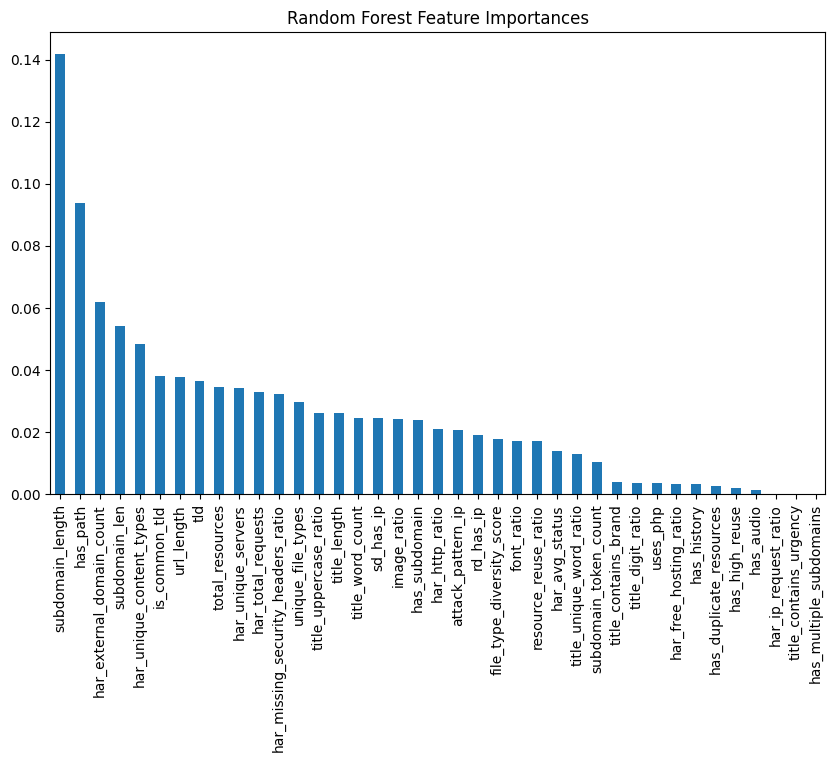

In [44]:
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
importances.plot(kind="bar")
plt.title("Random Forest Feature Importances")
plt.show()


In [45]:
xgb = XGBClassifier(n_estimators=200, random_state=42, use_label_encoder=False, eval_metric="logloss")
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

print("=== XGBoost ===")
print(classification_report(y_test, y_pred_xgb))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:52:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGBoost ===
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      6000
           1       0.99      0.98      0.98      5918

    accuracy                           0.98     11918
   macro avg       0.98      0.98      0.98     11918
weighted avg       0.98      0.98      0.98     11918



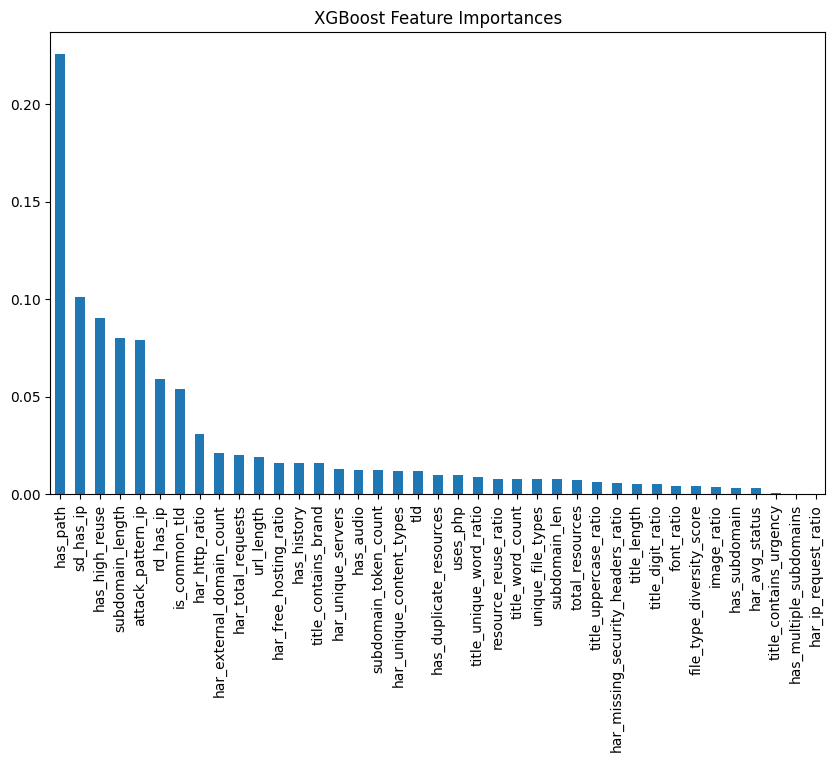

In [46]:
xgb_importances = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
xgb_importances.plot(kind="bar")
plt.title("XGBoost Feature Importances")
plt.show()


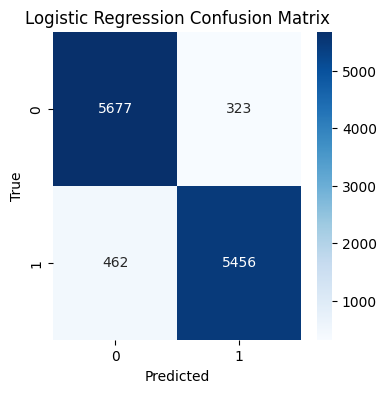

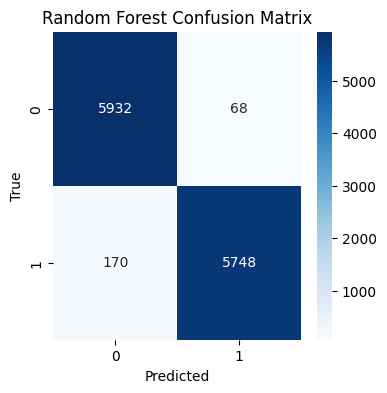

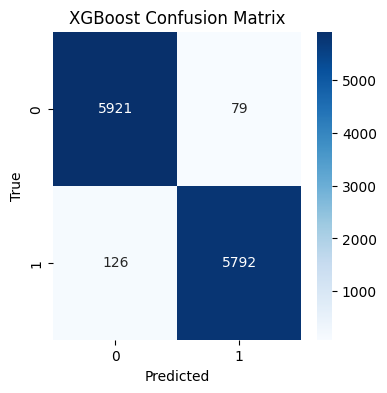

In [47]:
models = {"Logistic Regression": y_pred_lr, "Random Forest": y_pred_rf, "XGBoost": y_pred_xgb}

for name, y_pred in models.items():
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
